In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsforecast import StatsForecast
from statsforecast.models import  Naive, AutoARIMA, AutoCES, AutoTheta, AutoETS
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datasetsforecast.losses import mae, mape
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsforecast/core.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
warnings.filterwarnings("ignore")

In [3]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA', 'IBM', 'BTC-USD']
df = yf.download(tickers, start = '2018-01-01', end = '2022-12-31', interval='1mo')
df.head()

[*********************100%%**********************]  9 of 9 completed


Price       Adj Close                                                  \
Ticker           AAPL       AMZN       BTC-USD      GOOGL         IBM   
Date                                                                    
2018-01-01  39.477066  72.544502  10221.099609  59.043236  115.116302   
2018-02-01  41.997578  75.622498  10397.900391  55.132725  109.582001   
2018-03-01  39.720875  72.366997   6973.529785  51.797550  108.956596   
2018-04-01  39.124268  78.306503   9240.549805  50.870617  102.941681   
2018-05-01  44.240311  81.481003   7494.169922  54.936951  100.349686   

Price                                                       Close  ...  \
Ticker            META       MSFT      NVDA       TSLA       AAPL  ...   
Date                                                               ...   
2018-01-01  186.506729  88.362900  6.079518  23.620667  41.857498  ...   
2018-02-01  177.954330  87.209641  5.985529  22.870667  44.529999  ...   
2018-03-01  159.462311  85.283279  5.731614  17.742001  41.945000  ...   
2018-04-01  171.647278  87.385681  5.566044  19.593332  41.314999  ...   
2018-05-01  191.386719  92.356743  6.241443  18.982000  46.717499  ...   

Price            Open      Volume                                        \
Ticker           TSLA        AAPL        AMZN       BTC-USD       GOOGL   
Date                                                                      
2018-01-01  20.799999  2638717600  1927424000  416247858176   657748000   
2018-02-01  23.400000  3711577200  2755680000  229717780480  1026814000   
2018-03-01  23.000668  2854910800  2608002000  193751709184  1042336000   
2018-04-01  17.084000  2664617200  2598392000  196550010624   984928000   
2018-05-01  19.567333  2483905200  1432310000  197611709696   740734000   

Price                                                                 
Ticker            IBM       META       MSFT         NVDA        TSLA  
Date                                                                  
2018-01-01  151760375  495655700  574258400  11456216000  1864072500  
2018-02-01  107073687  516251600  725663300  14915528000  1637850000  
2018-03-01   98655478  996201700  750754800  14118440000  2359027500  
2018-04-01  128391583  750072700  668130700  11144008000  2854662000  
2018-05-01   92898293  401144100  509417900  11978240000  2333671500  

[5 rows x 54 columns]

In [4]:
df = df.loc[:, (['Adj Close'], tickers)]
df.columns = df.columns.droplevel() 
df = df.reset_index()
df.head()

Ticker,Date,AAPL,MSFT,GOOGL,AMZN,NVDA,META,TSLA,IBM,BTC-USD
0,2018-01-01,39.477066,88.362900,59.043236,72.544502,6.079518,186.506729,23.620667,115.116302,10221.099609
1,2018-02-01,41.997578,87.209641,55.132725,75.622498,5.985529,177.954330,22.870667,109.582001,10397.900391
2,2018-03-01,39.720875,85.283279,51.797550,72.366997,5.731614,159.462311,17.742001,108.956596,6973.529785
3,2018-04-01,39.124268,87.385681,50.870617,78.306503,5.566044,171.647278,19.593332,102.941681,9240.549805
4,2018-05-01,44.240311,92.356743,54.936951,81.481003,6.241443,191.386719,18.982000,100.349686,7494.169922


In [5]:
prices = df.melt(id_vars = 'Date')
prices = prices.rename(columns={'Date': 'ds', 'Ticker': 'unique_id', 'value': 'y'})
prices = prices[['unique_id', 'ds', 'y']]
prices

,unique_id,ds,y
0,AAPL,2018-01-01,39.477066
1,AAPL,2018-02-01,41.997578
2,AAPL,2018-03-01,39.720875
3,AAPL,2018-04-01,39.124268
4,AAPL,2018-05-01,44.240311
...,...,...,...
535,BTC-USD,2022-08-01,20049.763672
536,BTC-USD,2022-09-01,19431.789062
537,BTC-USD,2022-10-01,20495.773438
538,BTC-USD,2022-11-01,17168.566406


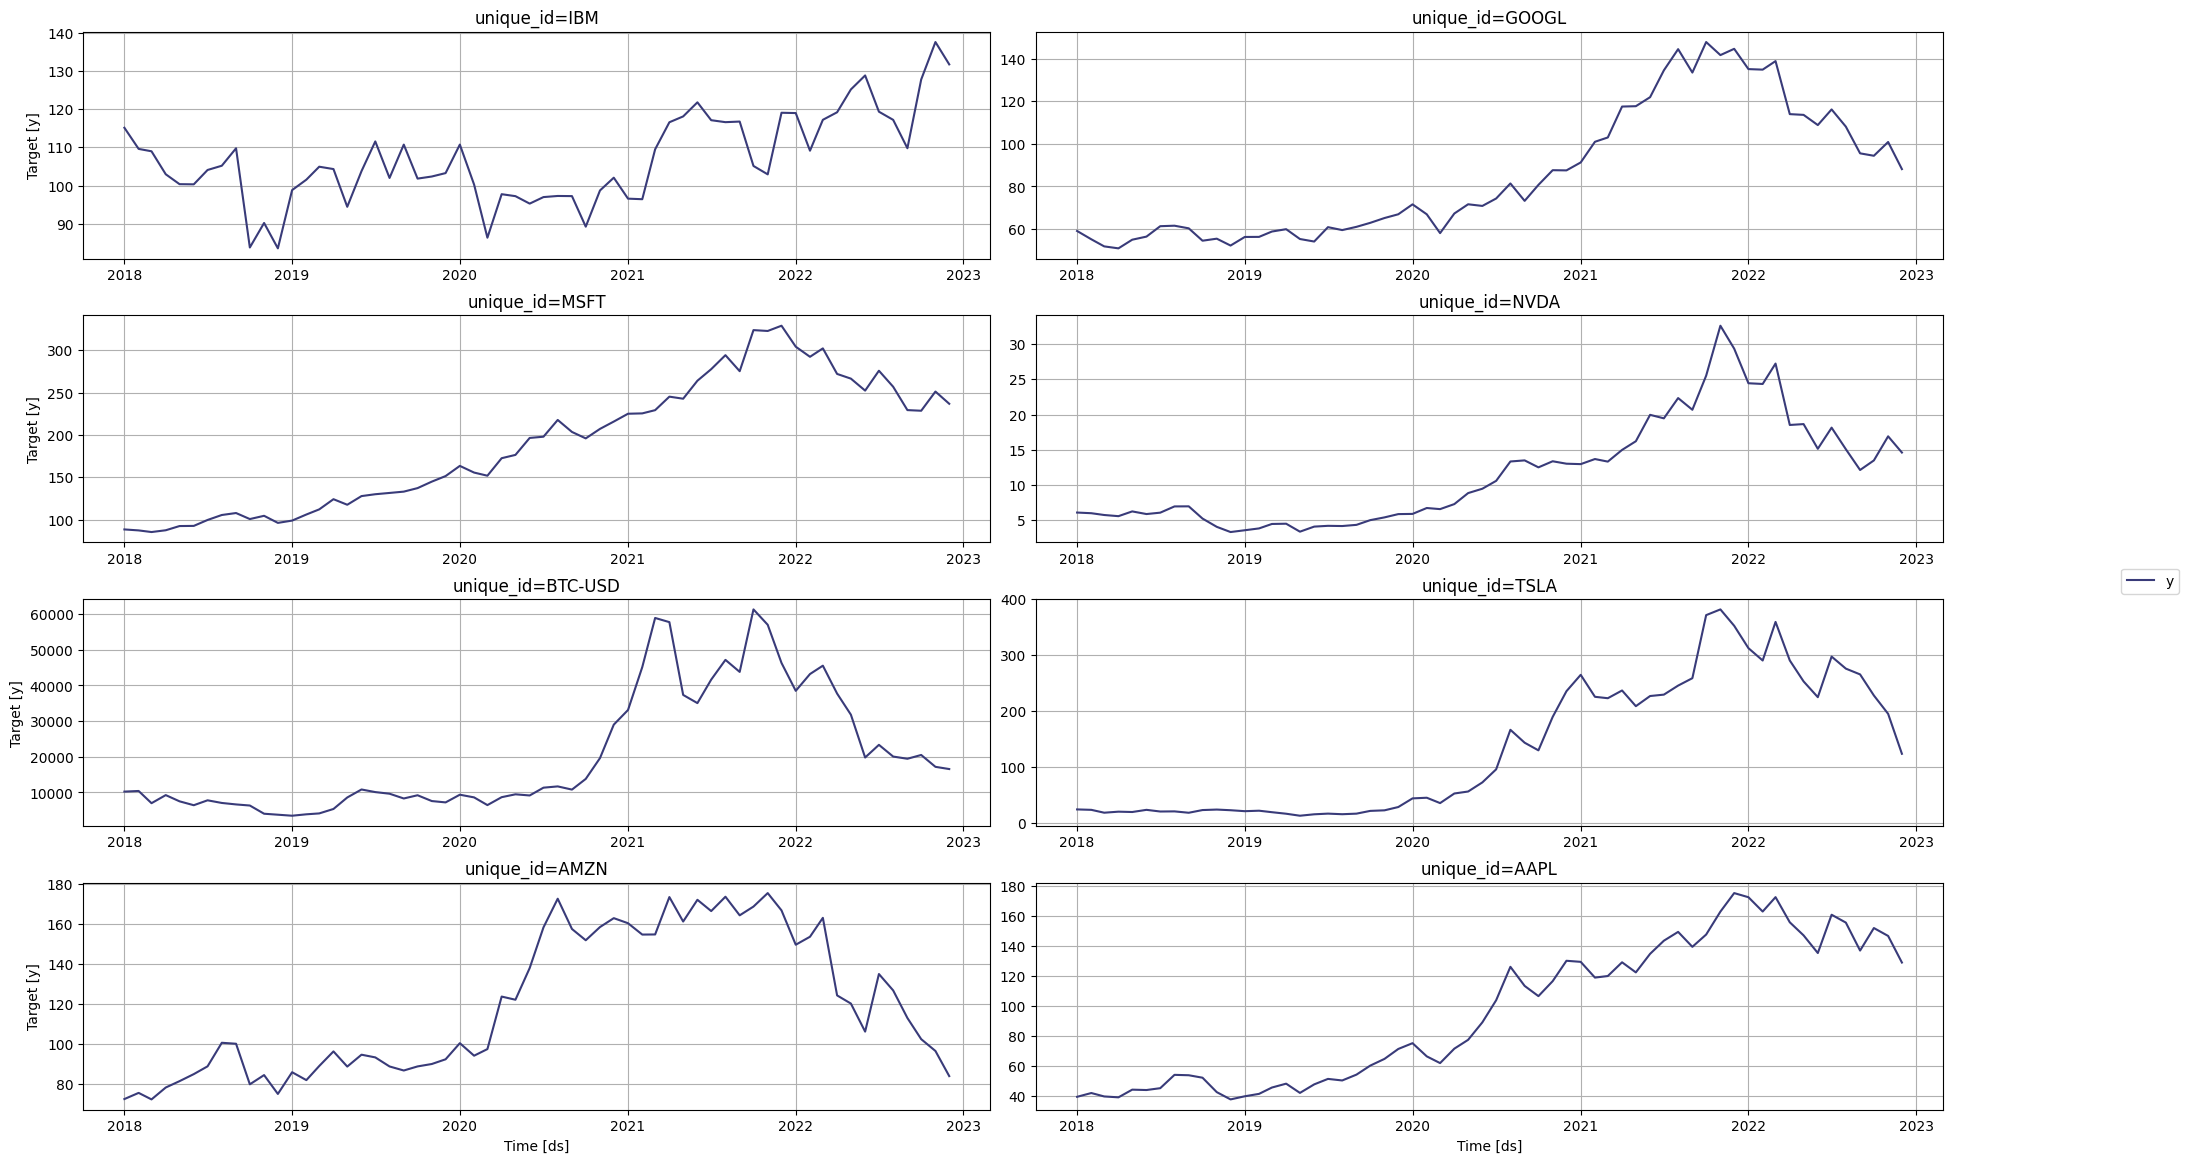

In [6]:
StatsForecast.plot(prices)

In [7]:
prices['rt'] = prices['y'].div(prices.groupby('unique_id')['y'].shift(1))
prices['rt'] = np.log(prices['rt'])

returns = prices[['unique_id', 'ds', 'rt']]
returns = returns.rename(columns={'rt':'y'})
returns = returns.dropna(subset=['y'])
returns

,unique_id,ds,y
1,AAPL,2018-02-01,0.061892
2,AAPL,2018-03-01,-0.055735
3,AAPL,2018-04-01,-0.015134
4,AAPL,2018-05-01,0.122893
5,AAPL,2018-06-01,-0.005614
...,...,...,...
535,BTC-USD,2022-08-01,-0.151818
536,BTC-USD,2022-09-01,-0.031307
537,BTC-USD,2022-10-01,0.053308
538,BTC-USD,2022-11-01,-0.177139


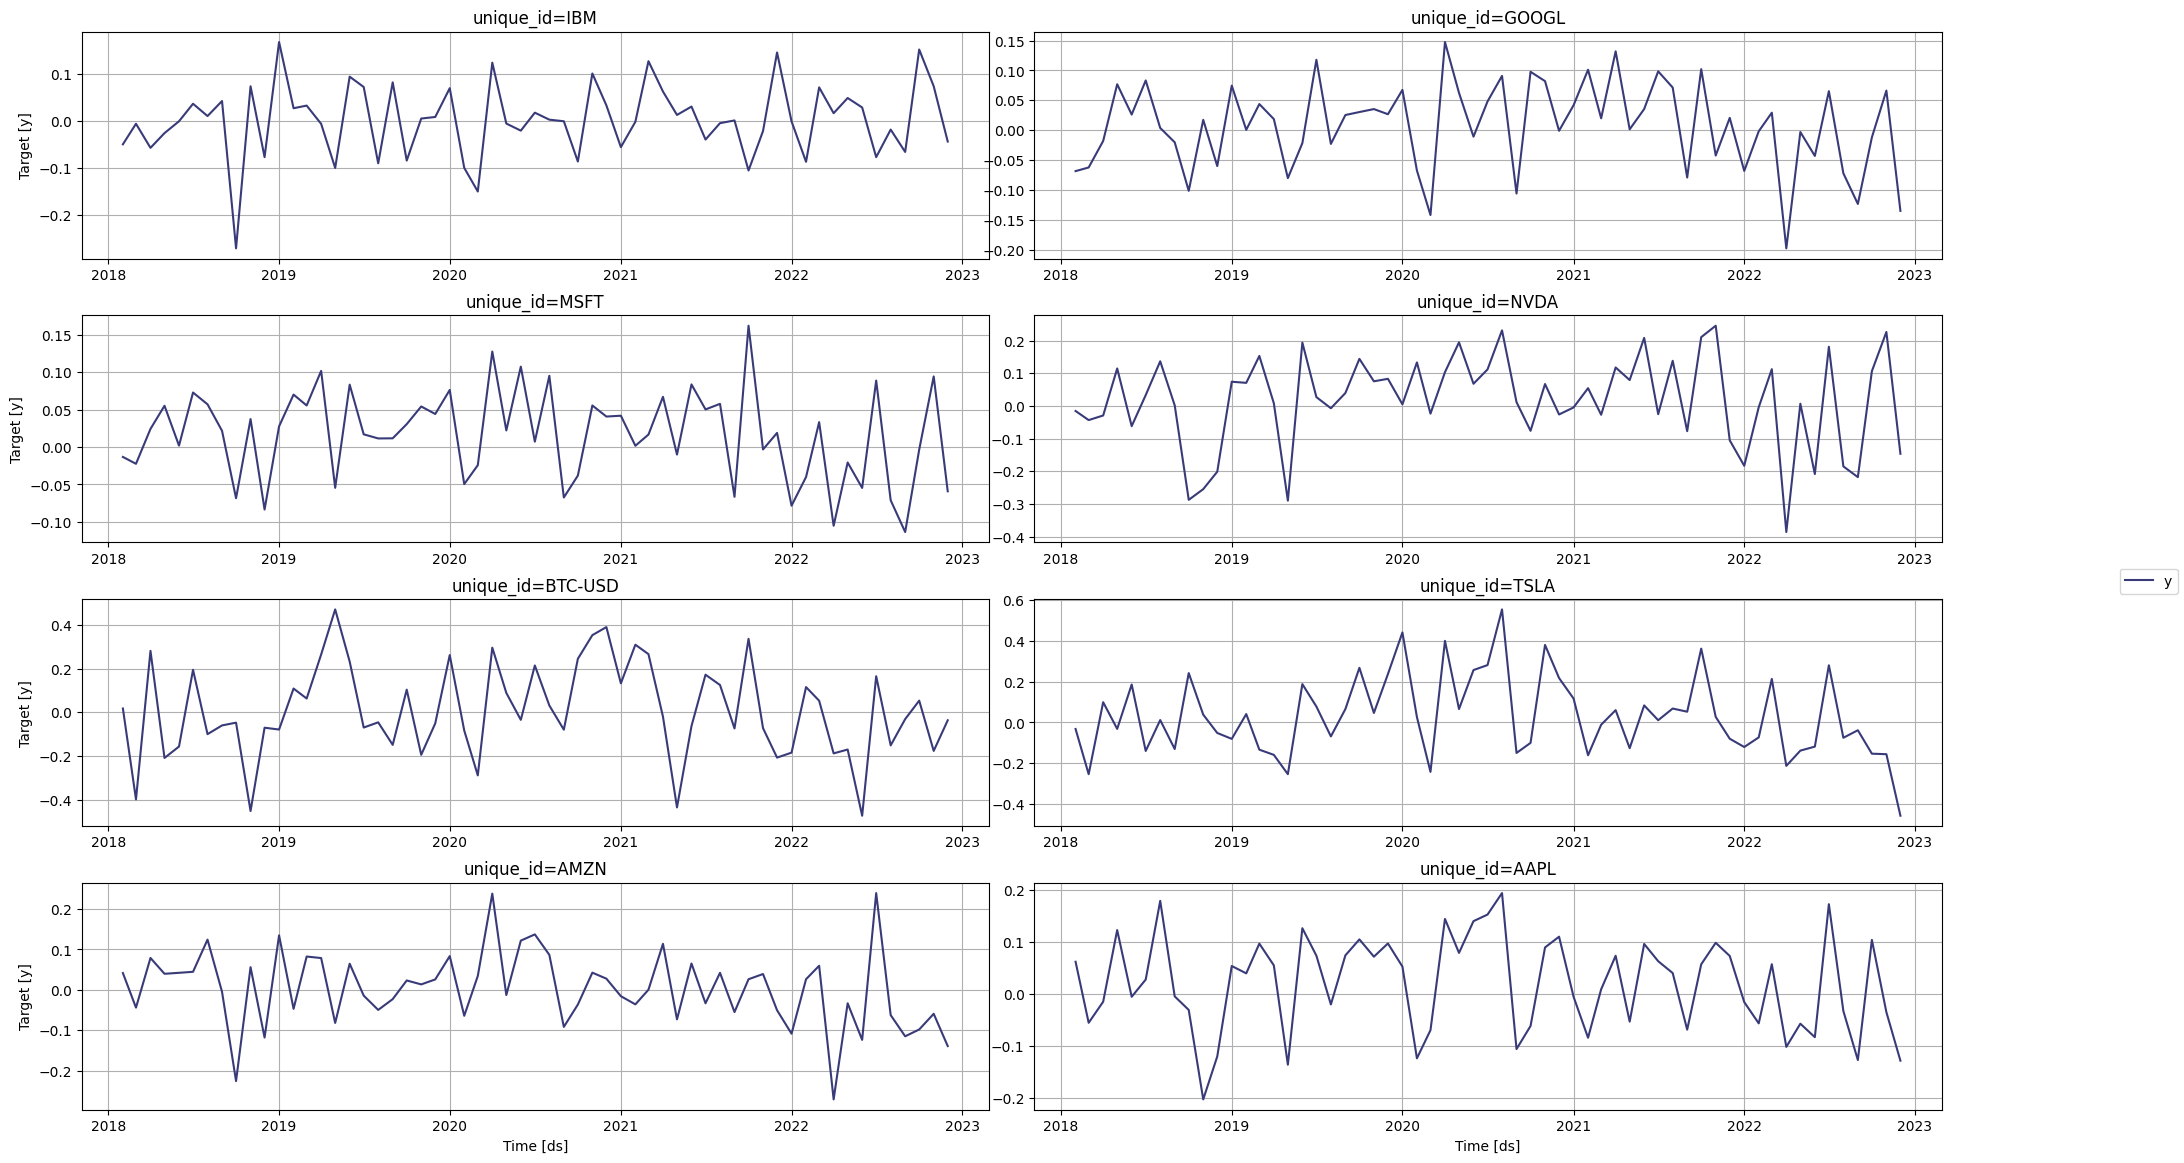

In [8]:
StatsForecast.plot(returns)

<Figure size 1500x2000 with 0 Axes>

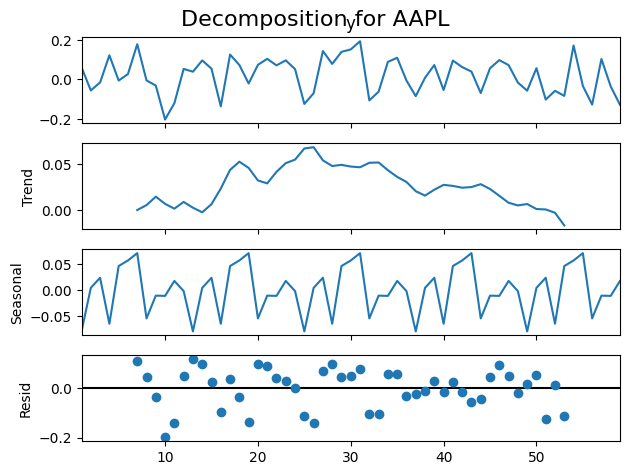

<Figure size 1500x2000 with 0 Axes>

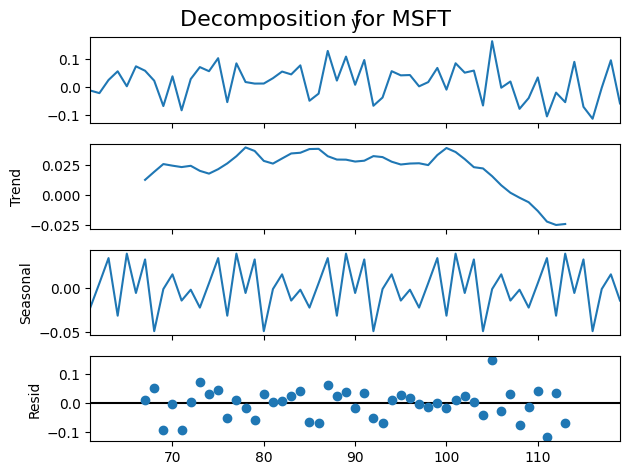

<Figure size 1500x2000 with 0 Axes>

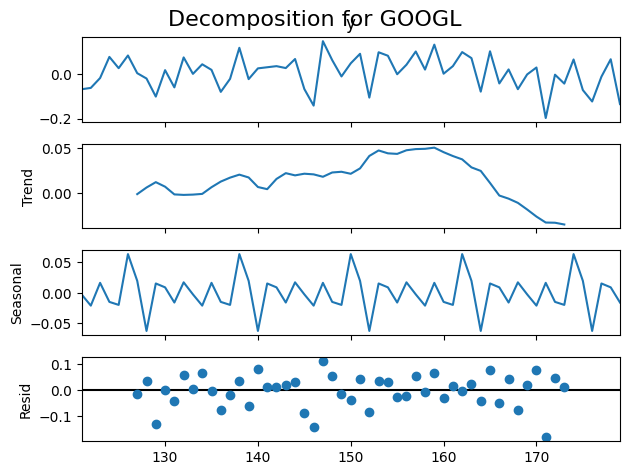

<Figure size 1500x2000 with 0 Axes>

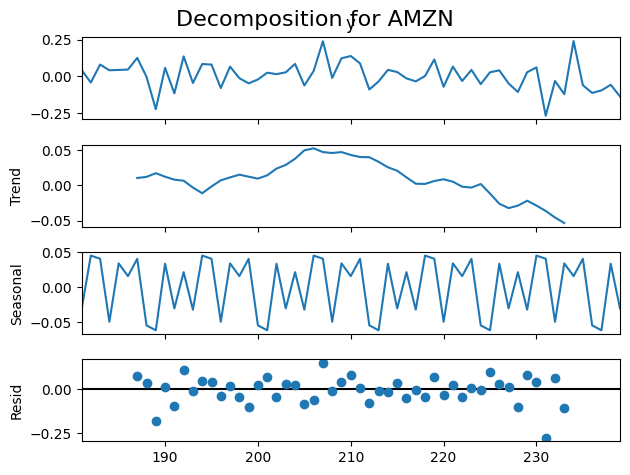

<Figure size 1500x2000 with 0 Axes>

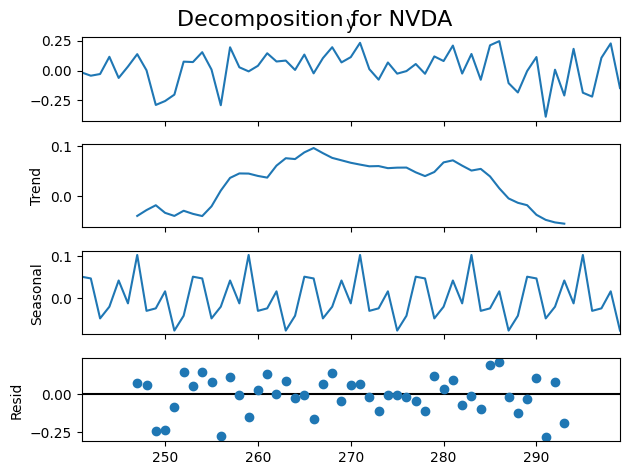

<Figure size 1500x2000 with 0 Axes>

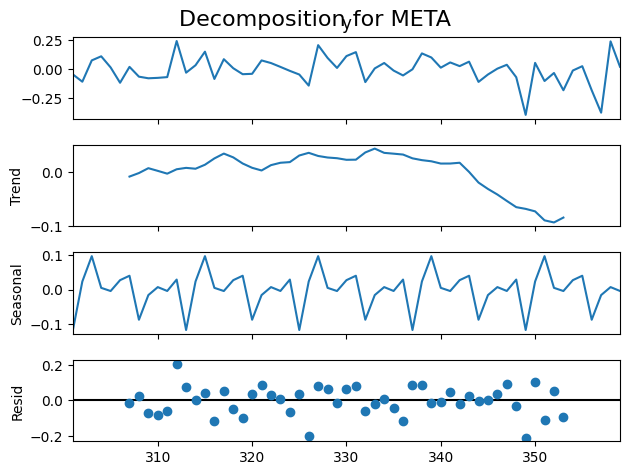

<Figure size 1500x2000 with 0 Axes>

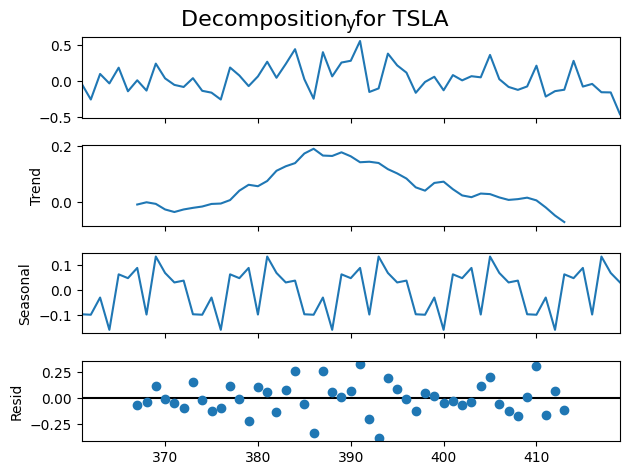

<Figure size 1500x2000 with 0 Axes>

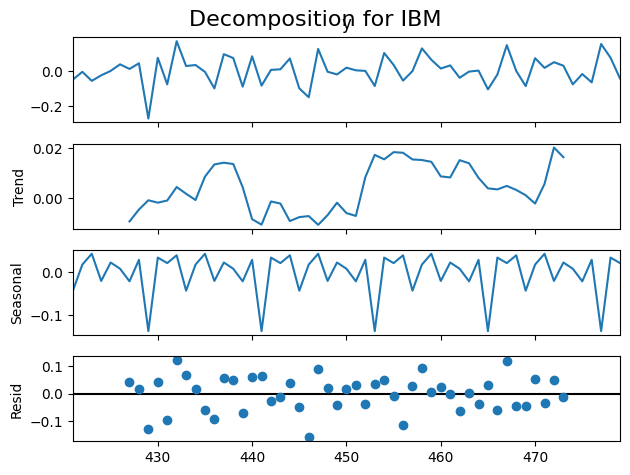

<Figure size 1500x2000 with 0 Axes>

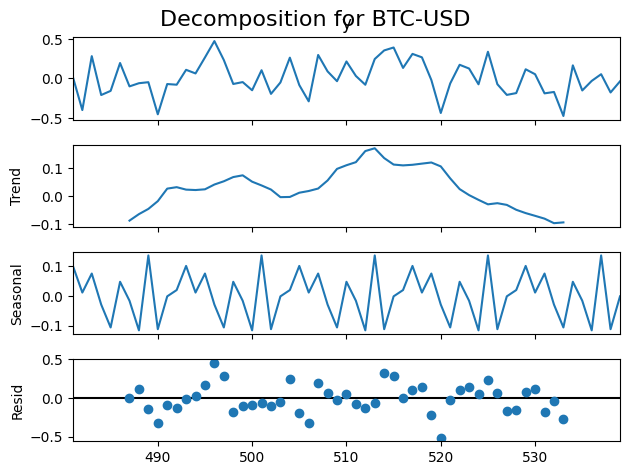

In [9]:
# Descomposición estacional
unique_ids = returns['unique_id'].unique()

for unique_id in unique_ids:
    series = returns[returns['unique_id'] == unique_id]
    
    # Asegurarse de que hay suficientes datos para la descomposición
    if len(series) >= 24:  # Al menos dos años de datos mensuales
        decomposition = seasonal_decompose(series['y'], model='additive', period=12)
        
        # Graficar
        plt.figure(figsize=(15, 20))
        decomposition.plot()
        plt.suptitle(f'Decomposition for {unique_id}', fontsize=16)
        plt.show()
    else:
        print(f"Not enough data to decompose for {unique_id}")

In [10]:
models = [Naive(), AutoCES(), AutoETS(), AutoTheta(), AutoARIMA()]

sf = StatsForecast(
    df = returns, 
    models = models, 
    freq = 'MS',
    n_jobs = -1
)
sf.fit()

StatsForecast(models=[Naive,CES,AutoETS,AutoTheta,AutoARIMA])

Modelo: Naive
No residuals found for Naive
Modelo: AutoCES


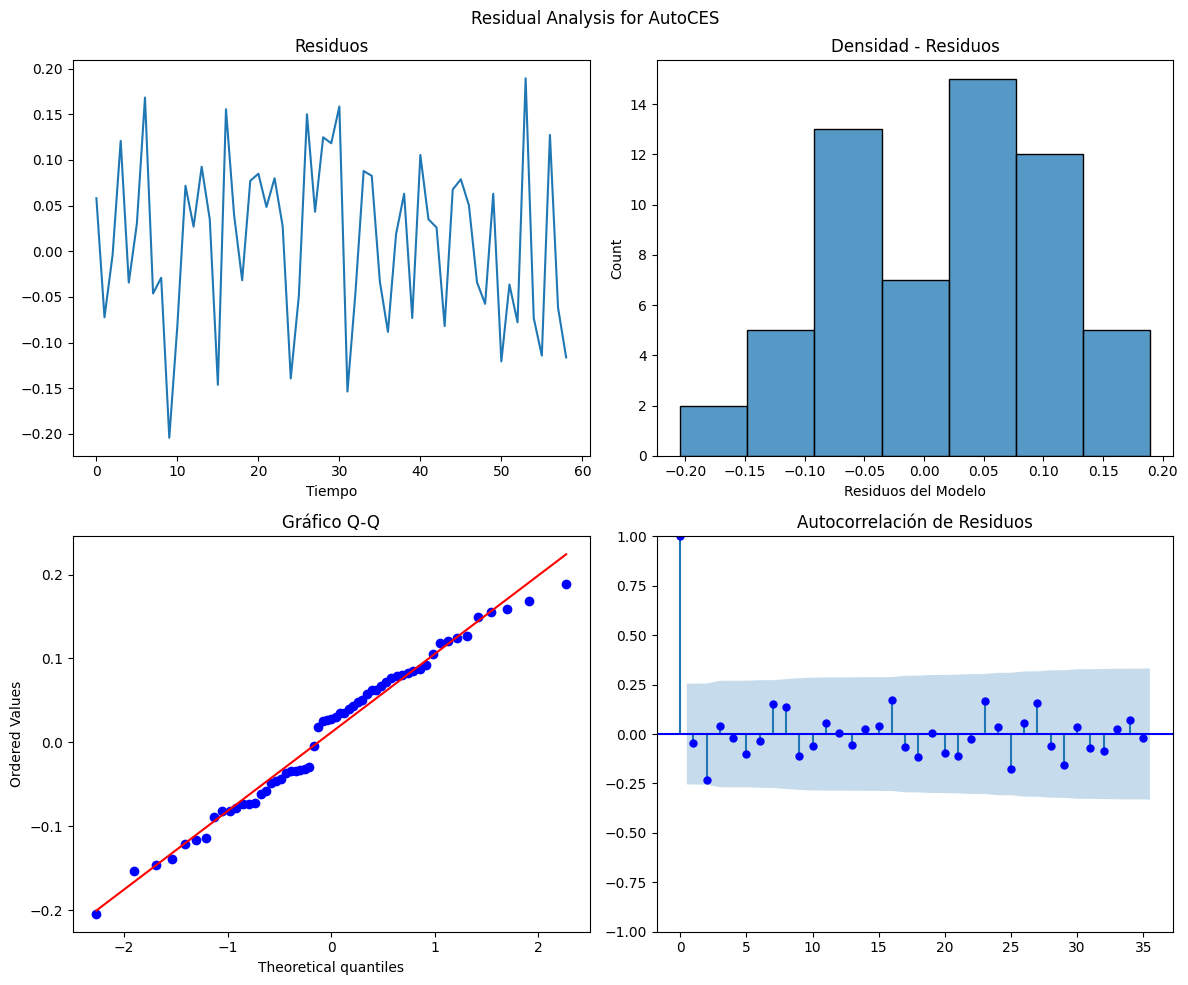

Modelo: AutoETS


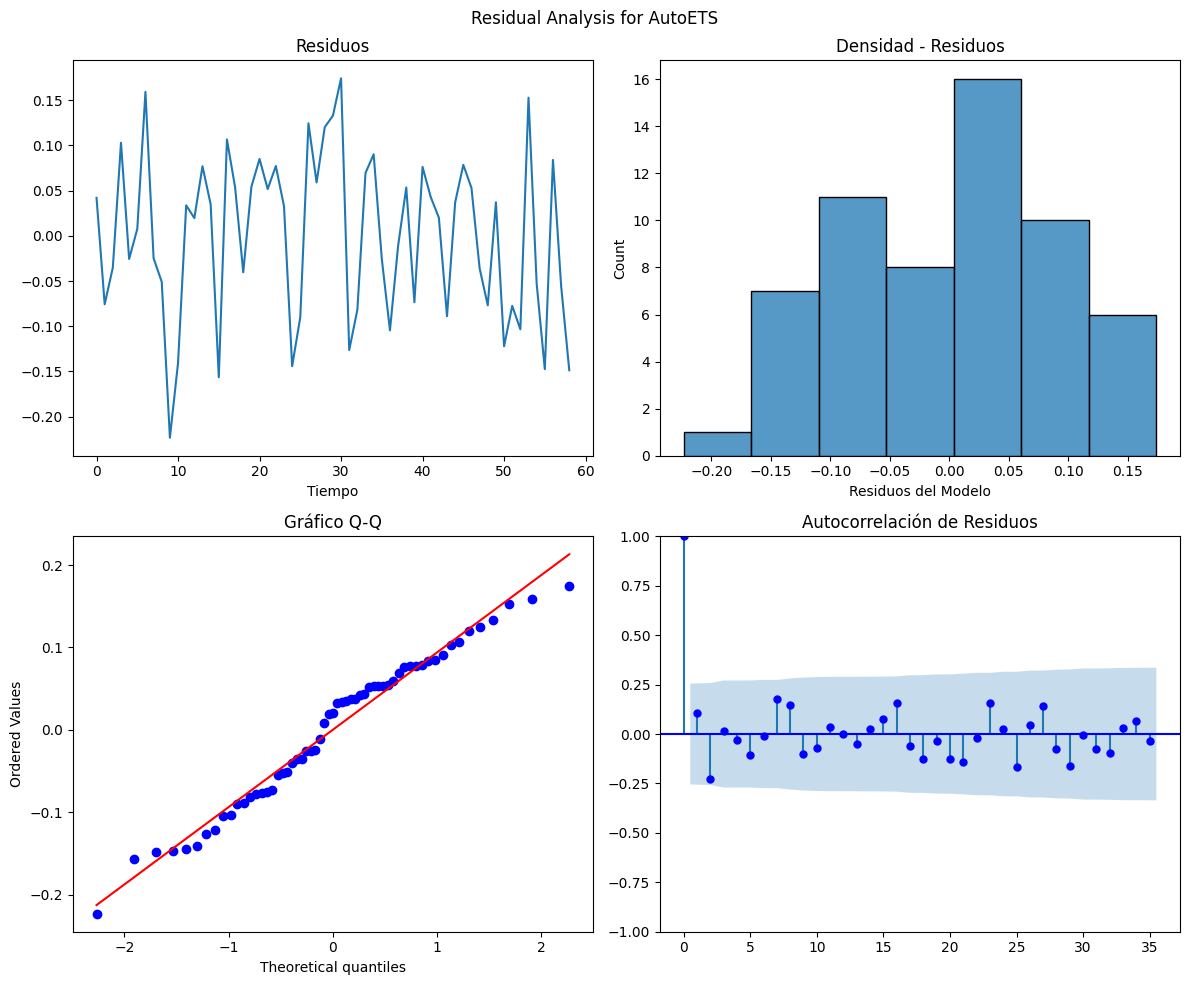

Modelo: AutoTheta


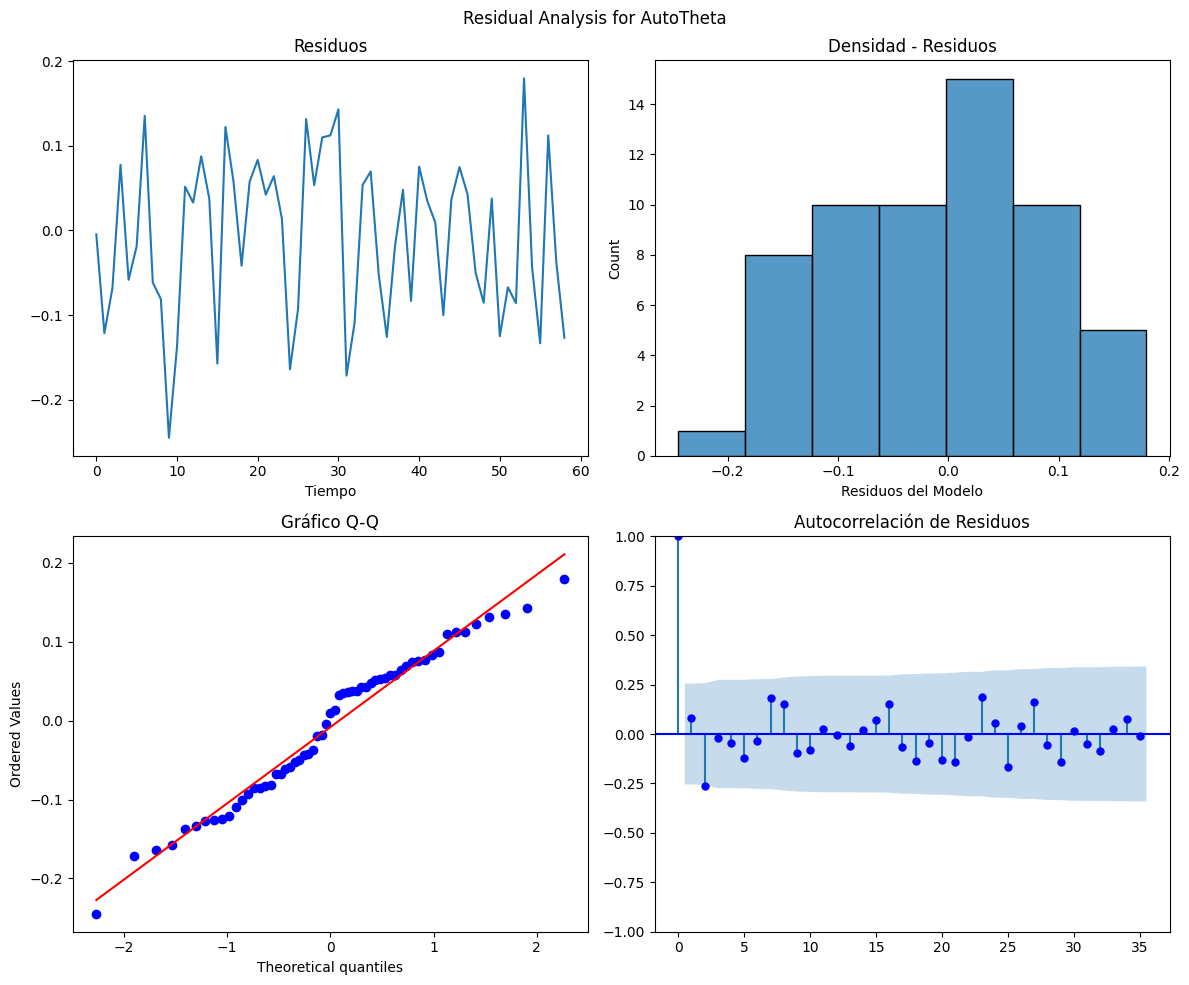

Modelo: AutoARIMA
(0, 0, 0, 0, 1, 0, 0)


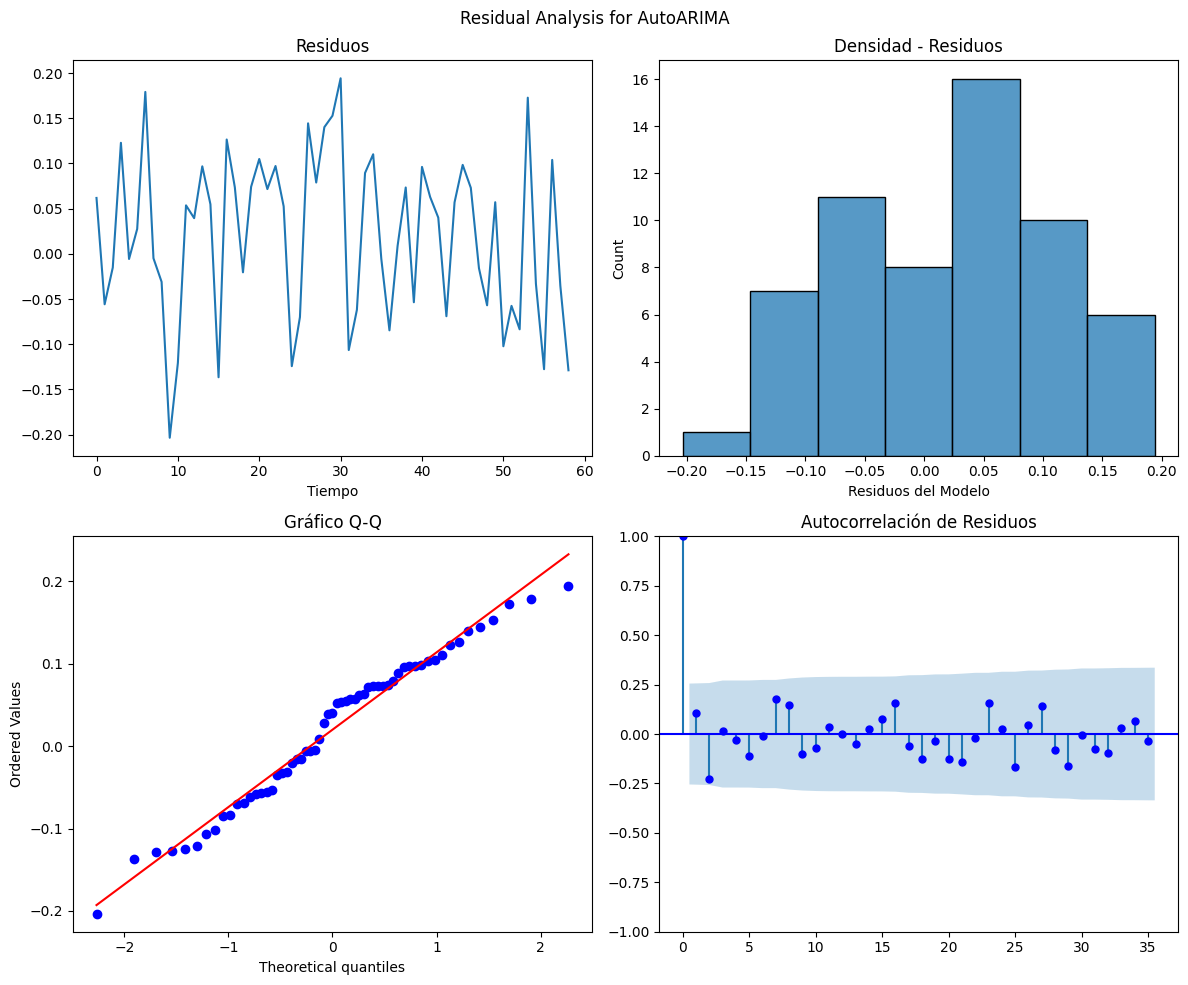

In [11]:
# Convertir sf.fitted_ a un diccionario
fitted_dict = {model_name: model_result for model_name, model_result in zip(models, sf.fitted_[0])}

# Iterar sobre los modelos ajustados y visualizar los residuos
for model in models:
    model_name = type(model).__name__
    model_result = fitted_dict[model]
    
    print(f"Modelo: {model_name}")

    # Verificar si el modelo tiene residuals
    if 'residuals' in model_result.model_:
        # Imprimir los componentes del modelo si están disponibles
        if 'arma' in model_result.model_:
            print(model_result.model_['arma'])

        # Residuales del modelo
        residual = pd.DataFrame(model_result.model_.get("residuals"), columns=["Residuos del Modelo"])

        # Visualización de los residuos
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

        # Residuales a lo largo del tiempo
        residual['Residuos del Modelo'].plot(ax=axs[0, 0])
        axs[0, 0].set_title("Residuos")
        axs[0, 0].set_xlabel('Tiempo')

        # Histograma de los residuos
        sns.histplot(residual['Residuos del Modelo'], ax=axs[0, 1])
        axs[0, 1].set_title("Densidad - Residuos")

        # Gráfico Q-Q
        stats.probplot(residual['Residuos del Modelo'], dist="norm", plot=axs[1, 0])
        axs[1, 0].set_title('Gráfico Q-Q')

        # ACF de los residuos
        plot_acf(residual['Residuos del Modelo'], lags=35, ax=axs[1, 1], color="blue")
        axs[1, 1].set_title("Autocorrelación de Residuos")

        plt.suptitle(f'Residual Analysis for {model_name}')
        plt.tight_layout()
        plt.show()
    else:
        print(f"No residuals found for {model_name}")

In [12]:
crossvalidation_df = sf.cross_validation(
    df = returns,
    h = 3,
    step_size = 3,
    n_windows = 4
  )

In [13]:
crossvalidation_df = crossvalidation_df.reset_index()
crossvalidation_df.rename(columns = {'y' : 'actual'}, inplace = True)
crossvalidation_df.head()

,unique_id,ds,cutoff,actual,Naive,CES,AutoETS,AutoTheta,AutoARIMA
0,AAPL,2022-01-01,2021-12-01,-0.015837,0.073061,0.022187,0.031785,0.043267,0.018206
1,AAPL,2022-02-01,2021-12-01,-0.056856,0.073061,0.006864,0.031785,0.043626,0.000000
2,AAPL,2022-03-01,2021-12-01,0.057156,0.073061,0.006258,0.031785,0.043986,0.000000
3,AAPL,2022-04-01,2022-03-01,-0.102178,0.057156,0.027445,0.029527,0.029916,0.027441
4,AAPL,2022-05-01,2022-03-01,-0.057505,0.057156,0.002996,0.029527,0.030082,0.000000


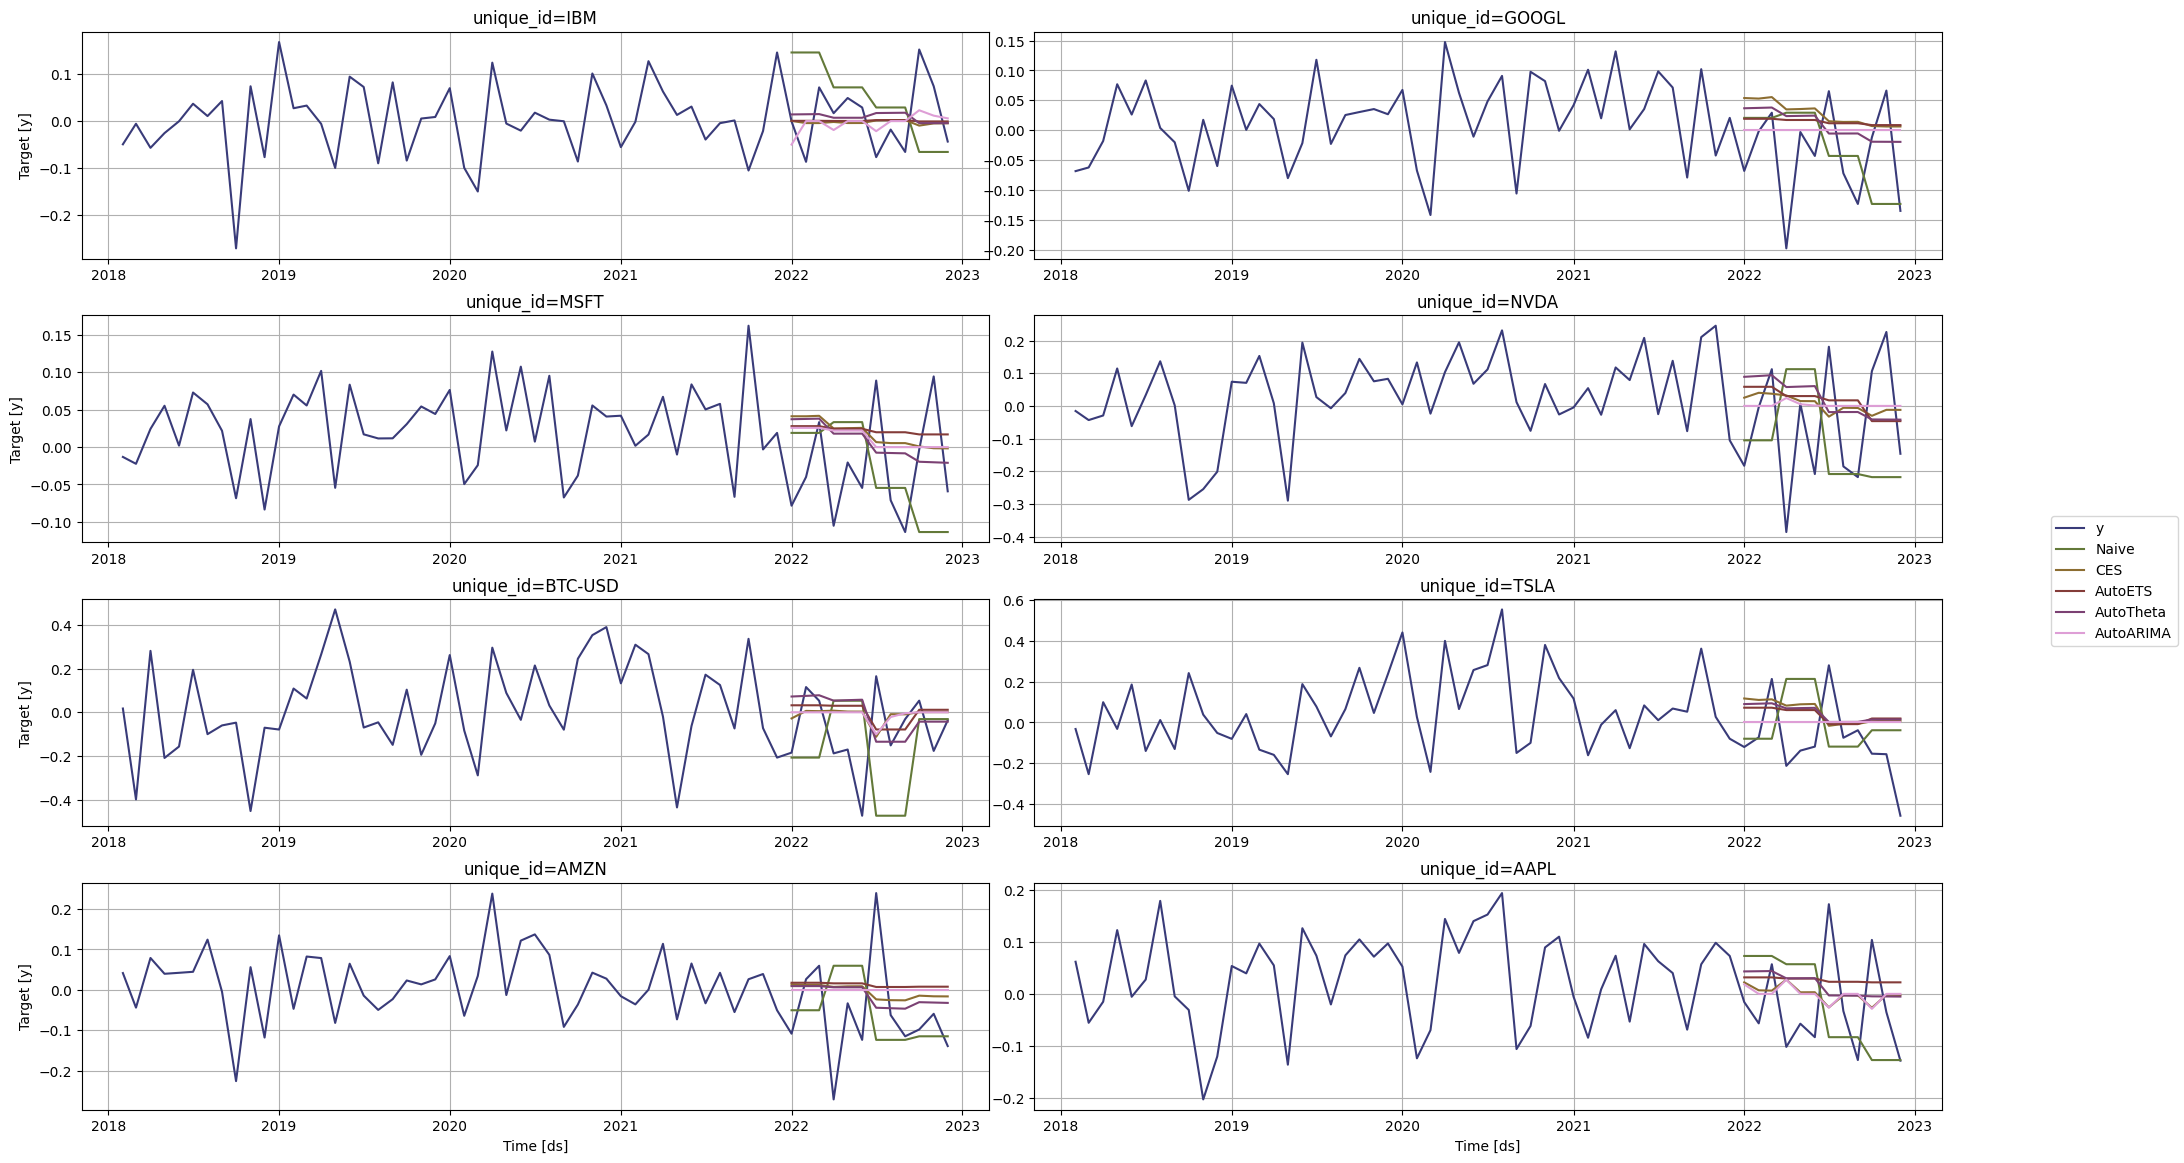

In [14]:
StatsForecast.plot(returns, crossvalidation_df.drop(['cutoff', 'actual'], axis=1))

In [15]:
# Suponiendo que ya tienes las funciones mae y mape definidas.
def mae(actual, predicted):
    return abs(actual - predicted).mean()

def mape(actual, predicted):
    return (abs((actual - predicted) / actual)).mean()

def compute_cv_errors(crossvalidation_df):
    """Compute MAE and MAPE for all models generated"""
    res = {}
    for mod in models:
        res[mod] = {
            'MAE': mae(crossvalidation_df['actual'], crossvalidation_df[str(mod)]),
            'MAPE': mape(crossvalidation_df['actual'], crossvalidation_df[str(mod)])
        }
    return pd.DataFrame(res).T  # Convertimos a DataFrame y transponemos para mejor formato

# Suponiendo que `models` está definido previamente como la lista de modelos
# y `crossvalidation_df` contiene los datos con las predicciones y los valores reales

errors_cv = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(compute_cv_errors)

# Calculando el promedio de los errores por `unique_id`
mean_errors = errors_cv.groupby('unique_id').mean()

print(mean_errors[['MAE', 'MAPE']])

                MAE      MAPE
unique_id                    
AAPL       0.095233  1.360983
AMZN       0.109932  0.991763
BTC-USD    0.180956  1.415511
GOOGL      0.078139  2.977920
IBM        0.067097  6.323030
META       0.150911  1.626616
MSFT       0.076120  1.893663
NVDA       0.184284  2.617344
TSLA       0.197185  1.217898
